<center><h1>VC05: Agrupamiento basado en densidad - Mean Shift</h1></center>

En esta práctica estudiaremos el funcionamiento y la utilización del agrupamiento basado en densidad, Desplazamiento de Medias o Mean Shift.

Para empezar, cargamos las librerías que vamos a necesitar:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import make_blobs


Empezamos creando el conjunto de datos con el que trabajaremos:


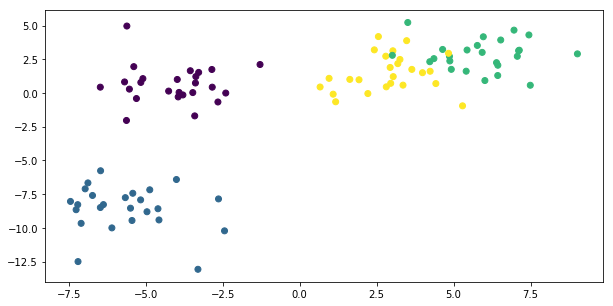

In [2]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

Dx, Dy = make_blobs(100, 2, centers=4, cluster_std=1.3)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy)


El algoritmo MeanShift usa la función kernel para delimitar el vecindario y devolver el peso de cada instancia del vecindario en el proceso de cálculo del centro. Para todo ello, sólo usa el parámetro $h$:


In [3]:
def kernel_gaussiano(mDistancia, i, h):
    dist = mDistancia[i,:]
    dist = np.exp(-(dist / h)**2)
    # Solo se aceptan los que estén en el vecindario
    dist[dist <= (1.0 / np.e)] = 0

    return dist


Posteriormente, sólo es necesario ejecutar el algoritmo. En cada iteración y para cada ejemplo $x_i$, se calcula el peso que tiene en el desplazamiento de $x_i$ cada ejemplo del conjunto de datos. En base a eso, se calcula el centro de masas mediante una suma ponderada. El centro calculado sustituye a $x_i$. Este procedimiento es aplicado iterativamente para todo el conjunto de datos.

Se consideran dos condiciones de parada: cuando ha convergido a los mismos centros o cuando se alcanza un número máximo de iteraciones.


In [4]:
def agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones = 100):
    Dx_hist = []
    Dx_hist.append(Dx)
    actDx = np.copy(Dx)
    for it in np.arange(n_iteraciones):
        mDistancia = euclidean_distances(actDx)

        for i in np.arange(actDx.shape[0]):

            weights = kernel_gaussiano(mDistancia, i, h)
            weights.shape = (mDistancia.shape[0], 1)
            numerador = np.sum(weights*actDx, axis=0)
            denominador = np.sum(weights)
            Xp = numerador / denominador

            actDx[i,:] = Xp
        
        Dx_hist.append(np.copy(actDx))
        
        if np.allclose(Dx_hist[it], Dx_hist[it+1]):
            break

    centros = np.unique(np.round(Dx_hist[len(Dx_hist)-1],3), axis=0)
    asignacion = np.argmin(euclidean_distances(Dx_hist[len(Dx_hist)-1], centros),axis=1)

    return [ Dx_hist , centros, asignacion]


Con estas dos funciones ya podemos ejecutar el algoritmo MeanShift. Sólo necesitamos asignar valor al parámetro que define el vecindario ($h$):


In [5]:
h=4

[Dx_hist, centros, Dyp] = agrupamiento_densidad_MeanShift(Dx, h)


Dibujamos los resultados de la siguiente manera:


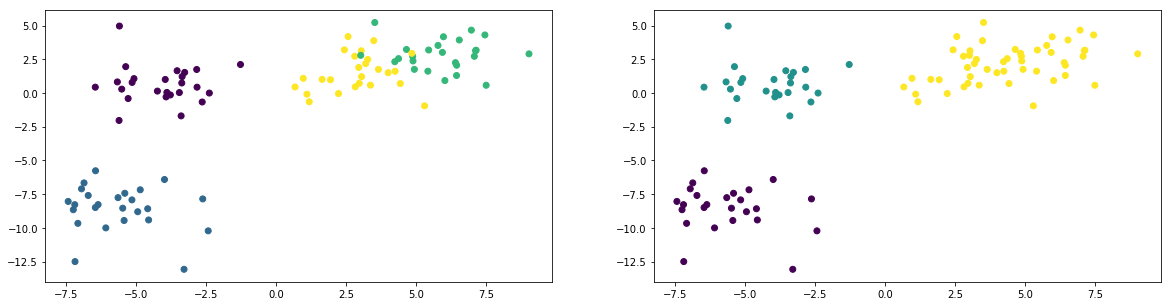

In [6]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = Dyp)


También podemos dibujar el desplazamiento de las medias hasta la configuración del agrupamiento final:


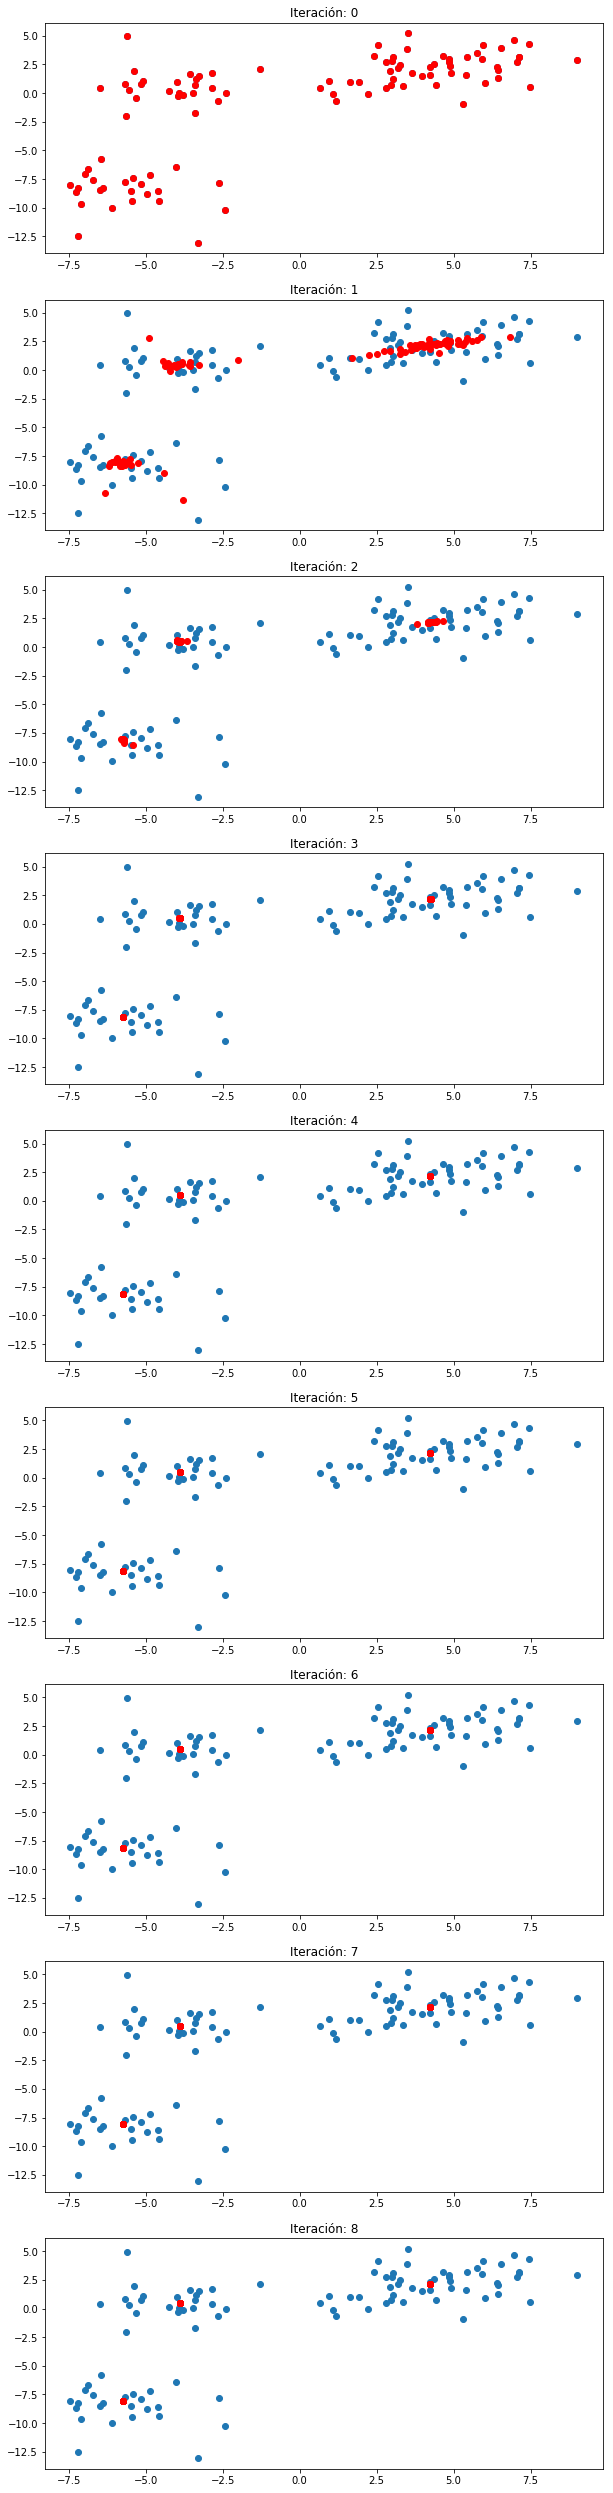

In [7]:
fig, ax = plt.subplots(len(Dx_hist), 1, figsize=(10,len(Dx_hist)*5))

for i in np.arange(len(Dx_hist)):
    ax[i].scatter(Dx[:,0], Dx[:,1])
    ax[i].set_title('Iteración: %d' % i)
    ax[i].plot(Dx_hist[i][:,0], Dx_hist[i][:,1], 'ro')


También se puede estudiar la bondad de la agrupación conociendo la realidad:


In [8]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

mC = matriz_confusion(Dy,Dyp)

print(mC)
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC),
      ' (** ESTE ES EL RESULTADO A INCLUIR EN EL CAMPUS**)')
print('El valor F1 es = ', medida_f1(mC))

[[ 0 25  0]
 [25  0  0]
 [ 0  0 25]
 [ 0  0 25]]
El valor del error cometido es =  0.0
La pureza del agrupamiento obtenido es =  0.75  (** ESTE ES EL RESULTADO A INCLUIR EN EL CAMPUS**)
El valor F1 es =  0.8333333333333333


<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering MeanShift.

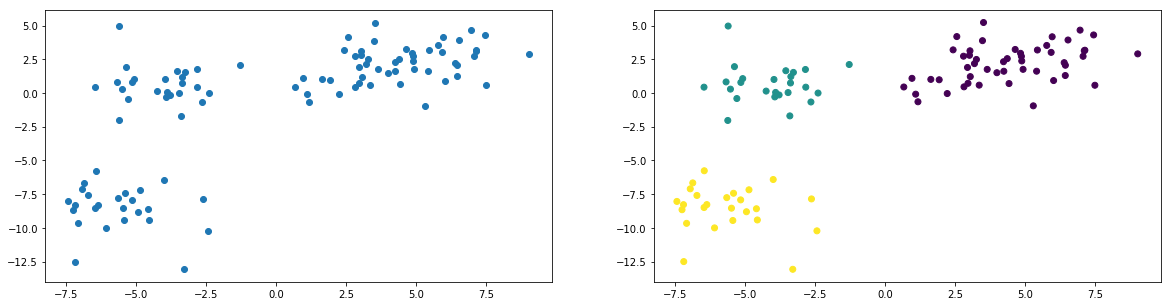

In [9]:
from sklearn.cluster import MeanShift

clustering = MeanShift(bandwidth = h).fit(Dx)

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1])#, c = Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = clustering.labels_)

<hr>
Podemos jugar con diferentes valores de $h$ para ver su efecto sobre diferentes conjuntos de datos:


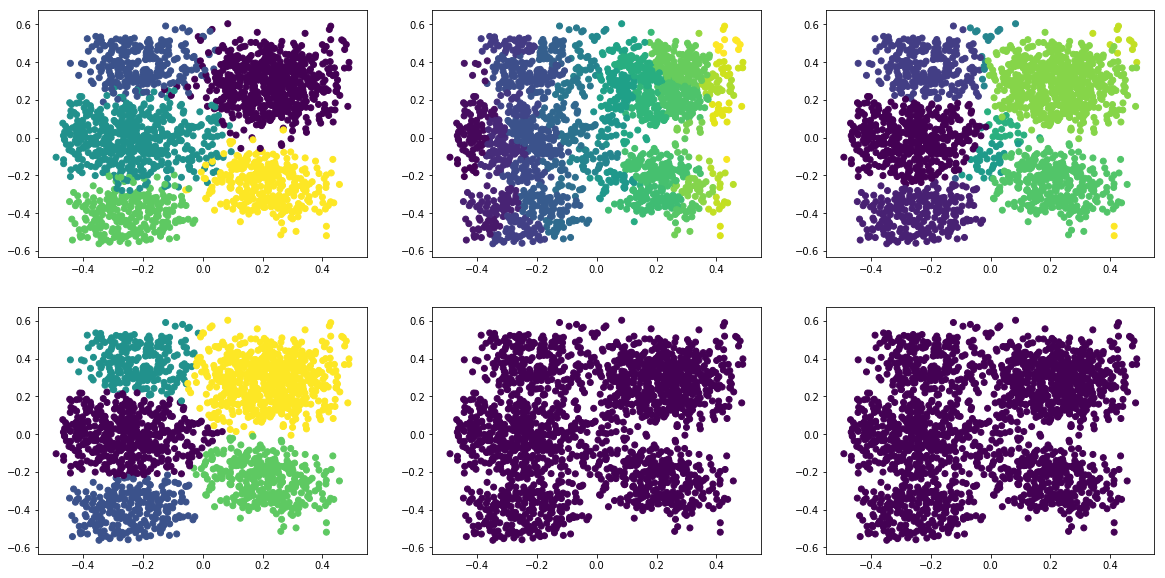

In [10]:
data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_inseparable.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

[Dx_hist, centros, Dyp1] = agrupamiento_densidad_MeanShift(Dx, h=0.05)
[Dx_hist, centros, Dyp2] = agrupamiento_densidad_MeanShift(Dx, h=0.1)
[Dx_hist, centros, Dyp3] = agrupamiento_densidad_MeanShift(Dx, h=0.2)
[Dx_hist, centros, Dyp4] = agrupamiento_densidad_MeanShift(Dx, h=0.3)
[Dx_hist, centros, Dyp5] = agrupamiento_densidad_MeanShift(Dx, h=0.4)

fig, ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[0,1].scatter(Dx[:,0], Dx[:,1], c = Dyp1)
ax[0,2].scatter(Dx[:,0], Dx[:,1], c = Dyp2)
ax[1,0].scatter(Dx[:,0], Dx[:,1], c = Dyp3)
ax[1,1].scatter(Dx[:,0], Dx[:,1], c = Dyp4)
ax[1,2].scatter(Dx[:,0], Dx[:,1], c = Dyp5)

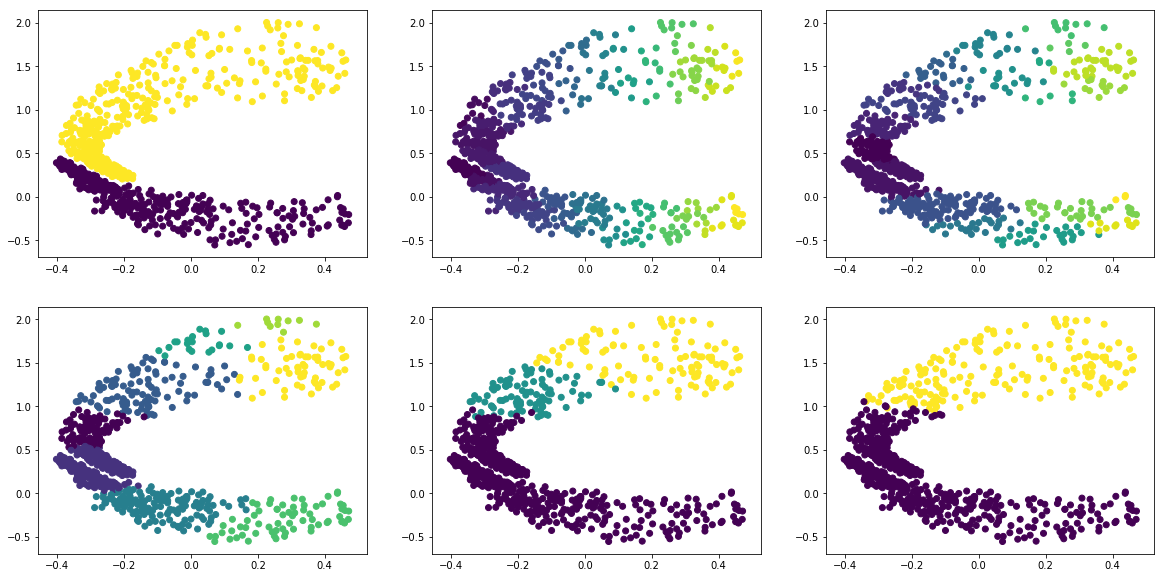

In [11]:
data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_dos_remolinos.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

mDistancia = euclidean_distances(Dx)

[Dx_hist, centros, Dyp1] = agrupamiento_densidad_MeanShift(Dx, h=0.05)
[Dx_hist, centros, Dyp2] = agrupamiento_densidad_MeanShift(Dx, h=0.1)
[Dx_hist, centros, Dyp3] = agrupamiento_densidad_MeanShift(Dx, h=0.2)
[Dx_hist, centros, Dyp4] = agrupamiento_densidad_MeanShift(Dx, h=0.3)
[Dx_hist, centros, Dyp5] = agrupamiento_densidad_MeanShift(Dx, h=0.4)

fig, ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[0,1].scatter(Dx[:,0], Dx[:,1], c = Dyp1)
ax[0,2].scatter(Dx[:,0], Dx[:,1], c = Dyp2)
ax[1,0].scatter(Dx[:,0], Dx[:,1], c = Dyp3)
ax[1,1].scatter(Dx[:,0], Dx[:,1], c = Dyp4)
ax[1,2].scatter(Dx[:,0], Dx[:,1], c = Dyp5)

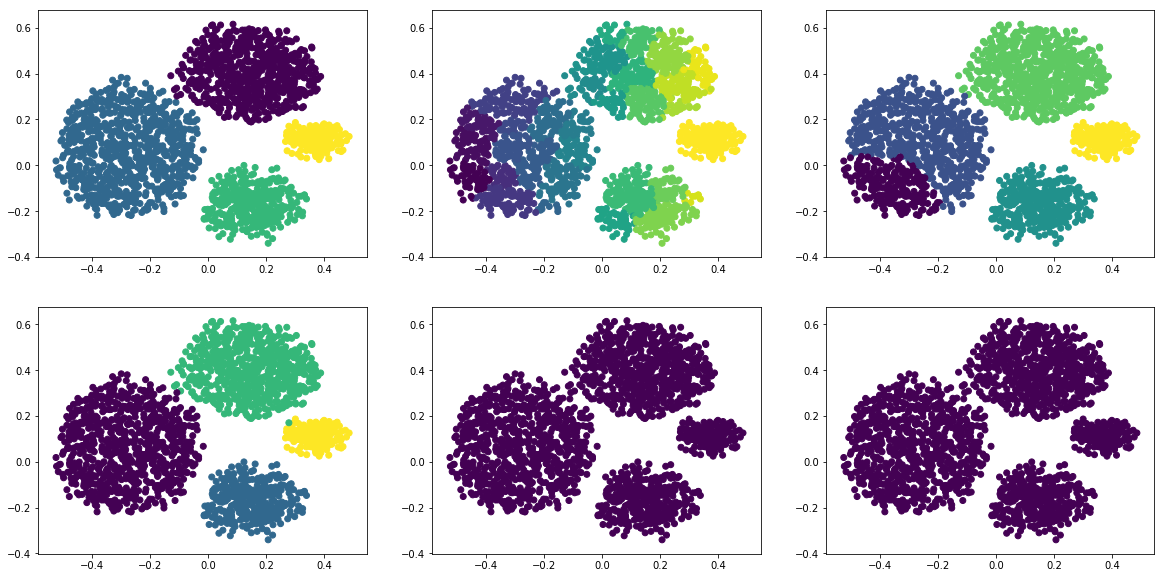

In [12]:
data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_medida.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

mDistancia = euclidean_distances(Dx)

[Dx_hist, centros, Dyp1] = agrupamiento_densidad_MeanShift(Dx, h=0.05)
[Dx_hist, centros, Dyp2] = agrupamiento_densidad_MeanShift(Dx, h=0.1)
[Dx_hist, centros, Dyp3] = agrupamiento_densidad_MeanShift(Dx, h=0.2)
[Dx_hist, centros, Dyp4] = agrupamiento_densidad_MeanShift(Dx, h=0.3)
[Dx_hist, centros, Dyp5] = agrupamiento_densidad_MeanShift(Dx, h=0.4)

fig, ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[0,1].scatter(Dx[:,0], Dx[:,1], c = Dyp1)
ax[0,2].scatter(Dx[:,0], Dx[:,1], c = Dyp2)
ax[1,0].scatter(Dx[:,0], Dx[:,1], c = Dyp3)
ax[1,1].scatter(Dx[:,0], Dx[:,1], c = Dyp4)
ax[1,2].scatter(Dx[:,0], Dx[:,1], c = Dyp5)